# Instructions



# Setup


In [1]:
# SET THESE BEFORE EXECUTION

save_dataset_to_drive = False  # saves dataframe after cleaning/tokenizing
save_model_to_drive = False  # saves vectorizer and model after training

# dataset to import (specify this even when importing from drive)
kaggle_dataset = 'snap/amazon-fine-food-reviews'
#kaggle_dataset = 'eswarchandt/amazon-music-reviews'

# type of logistic regression model to use (based on which dataset it was trained on)
lr_model = 'amazon-fine-food-reviews'
#lr_model = 'amazon-music-reviews'

In [2]:
if kaggle_dataset == 'snap/amazon-fine-food-reviews':
  review_text = "Text"
  review_rating = "Score"
elif kaggle_dataset == 'eswarchandt/amazon-music-reviews':
  review_text = "reviewText"
  review_rating = "overall"

## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import pickle
import glob
from google.colab import drive

In [4]:
# Make sure you added the shared project folder to your drive
drive.mount('/content/drive')
project_folder = '/content/drive/MyDrive/CIS 519 Project'

Mounted at /content/drive


In [5]:
# Clear files from any past session
files = glob.glob("*.*")
for f in files:
    ! rm '{f}'

In [6]:
# Run this to load in the saved dataset if you don't want to retokenize (skip to bag of words code section)
if not save_dataset_to_drive:
  path = project_folder + '/' + kaggle_dataset.split('/')[1] + '-prepared-dataset.csv'

  prepared_dataset = pd.read_csv(path).drop(['Unnamed: 0'], axis=1)
  print(prepared_dataset)

                UserId   ProductId  Score  HelpfulnessNumerator  \
0       A3SGXH7AUHU8GW  B001E4KFG0      5                     1   
1       A1D87F6ZCVE5NK  B00813GRG4      1                     0   
2        ABXLMWJIXXAIN  B000LQOCH0      4                     1   
3       A395BORC6FGVXV  B000UA0QIQ      2                     3   
4       A1UQRSCLF8GW1T  B006K2ZZ7K      5                     0   
...                ...         ...    ...                   ...   
568422  A28KG5XORO54AY  B001EO7N10      5                     0   
568423  A3I8AFVPEE8KI5  B003S1WTCU      2                     0   
568424  A121AA1GQV751Z  B004I613EE      5                     2   
568425   A3IBEVCTXKNOH  B004I613EE      5                     1   
568426  A3LGQPJCZVL9UC  B001LR2CU2      5                     0   

        HelpfulnessDenominator                             Summary  \
0                            1               Good Quality Dog Food   
1                            0                   Not as

In [7]:
# Run this to load in the saved model if you don't want to retrain (skip to bag of words code section)
if not save_model_to_drive:
  path = project_folder + '/' + lr_model + '-lr-model.pkl'

  with open(path, 'rb') as f:
      lr_bow = pickle.load(f)
      
  print(lr_bow)

LogisticRegression(max_iter=500, random_state=0, solver='sag')


## Download/Read Data

In [8]:
# use Avi's kaggle api key to permit downloading the data
! mkdir ~/.kaggle
! cp '{project_folder}/kaggle.json' ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
# download the dataset
! pip install kaggle
! kaggle datasets download --unzip {kaggle_dataset}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 96% 232M/242M [00:01<00:00, 156MB/s]
100% 242M/242M [00:01<00:00, 162MB/s]


# Data Wrangling

In [10]:
csv_path = glob.glob("*.csv")[0]
print(csv_path)

Reviews.csv


## Exploration

In [11]:
raw_dataset = pd.read_csv(csv_path)

In [12]:
# what a review looks like
raw_dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [13]:
# get columns
for col in raw_dataset.columns:
    print(col)

Id
ProductId
UserId
ProfileName
HelpfulnessNumerator
HelpfulnessDenominator
Score
Time
Summary
Text


In [14]:
# ID col isn't particularly useful, its just the index of the review
# Profile Name is redundant with UserId
# I don't expect we'll use the time of the review, leaving out for now

if kaggle_dataset == 'snap/amazon-fine-food-reviews':
  selected_cols = ["UserId", "ProductId", "Score", "HelpfulnessNumerator", "HelpfulnessDenominator", "Summary", "Text"]
elif kaggle_dataset == 'eswarchandt/amazon-music-reviews':
  selected_cols = ["reviewerID", "asin", "overall", "helpful", "summary", "reviewText"]

simplified_dataset = raw_dataset[selected_cols]

In [15]:
simplified_dataset.head(2)

,UserId,ProductId,Score,HelpfulnessNumerator,HelpfulnessDenominator,Summary,Text
0,A3SGXH7AUHU8GW,B001E4KFG0,5,1,1,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,B00813GRG4,1,0,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [16]:
print(simplified_dataset.describe())

               Score  HelpfulnessNumerator  HelpfulnessDenominator
count  568454.000000         568454.000000            568454.00000
mean        4.183199              1.743817                 2.22881
std         1.310436              7.636513                 8.28974
min         1.000000              0.000000                 0.00000
25%         4.000000              0.000000                 0.00000
50%         5.000000              0.000000                 1.00000
75%         5.000000              2.000000                 2.00000
max         5.000000            866.000000               923.00000


In [17]:
# rating distribution
print(simplified_dataset[review_rating].value_counts())

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64


## Cleaning

In [18]:
# Detect any NaNs
print(simplified_dataset.isnull().any())

UserId                    False
ProductId                 False
Score                     False
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Summary                    True
Text                      False
dtype: bool


In [19]:
# print rows with missing data
rows_missing = simplified_dataset[simplified_dataset.isnull().any(axis=1)]

print(rows_missing.count())

UserId                    27
ProductId                 27
Score                     27
HelpfulnessNumerator      27
HelpfulnessDenominator    27
Summary                    0
Text                      27
dtype: int64


In [20]:
# this is the cleaned dataset we want to be using
if kaggle_dataset == 'snap/amazon-fine-food-reviews':
  dataset = simplified_dataset[simplified_dataset['Summary'].notna()]
elif kaggle_dataset == 'eswarchandt/amazon-music-reviews':
  dataset = simplified_dataset[simplified_dataset['reviewText'].notna()]

# print(cleaned_ds.describe())
print(dataset.head(1))

           UserId   ProductId  Score  HelpfulnessNumerator  \
0  A3SGXH7AUHU8GW  B001E4KFG0      5                     1   

   HelpfulnessDenominator                Summary  \
0                       1  Good Quality Dog Food   

                                                Text  
0  I have bought several of the Vitality canned d...  


## Tokenize and Lemmatize

In [21]:
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

In [22]:
def get_tokens(text):
  return word_tokenize(text)

In [23]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
# stop words from nltk
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)

# add punctuation to stopwords set
stop.update(punctuation)

In [25]:
# map to POS format for nltk WordNetLemmatizer
def get_pos(w):
  if w.startswith('J'):
    return wordnet.ADJ
  elif w.startswith('V'):
    return wordnet.VERB
  elif w.startswith('N'):
    return wordnet.NOUN
  elif w.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

In [26]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    out = []

    # for w in text.split():
    for w in get_tokens(text):
      w_clean = w.strip().lower()
      # ignore stop words
      if w_clean not in stop:
        pos = pos_tag([w_clean]) # part of speech from nltk
        # print(w_clean, get_pos(pos[0][1]))
        word = lemmatizer.lemmatize(w_clean, get_pos(pos[0][1]))
        out.append(word)

    return " ".join(out)

In [27]:
def test_lemmatize():
    sent = dataset.iloc[0][review_text]
    result = lemmatize_words(sent)
    print(get_tokens(sent), "\n", result)

test_lemmatize()

['I', 'have', 'bought', 'several', 'of', 'the', 'Vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', '.', 'The', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', '.', 'My', 'Labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most', '.'] 
 bought several vitality can dog food product found good quality product look like stew process meat smell well labrador finicky appreciates product well


In [28]:
if save_dataset_to_drive:
  dataset[review_text] = dataset[review_text].apply(lemmatize_words)

  prepared_dataset = dataset

  # save
  path = project_folder + '/' + kaggle_dataset.split('/')[1] + '-prepared-dataset.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    dataset.to_csv(f)

# Bag of Words Featurization

## Split dataset

In [29]:
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

In [30]:
x_train,x_test,y_train,y_test = train_test_split(prepared_dataset[review_text], prepared_dataset[review_rating], test_size = 0.3, random_state = 0)

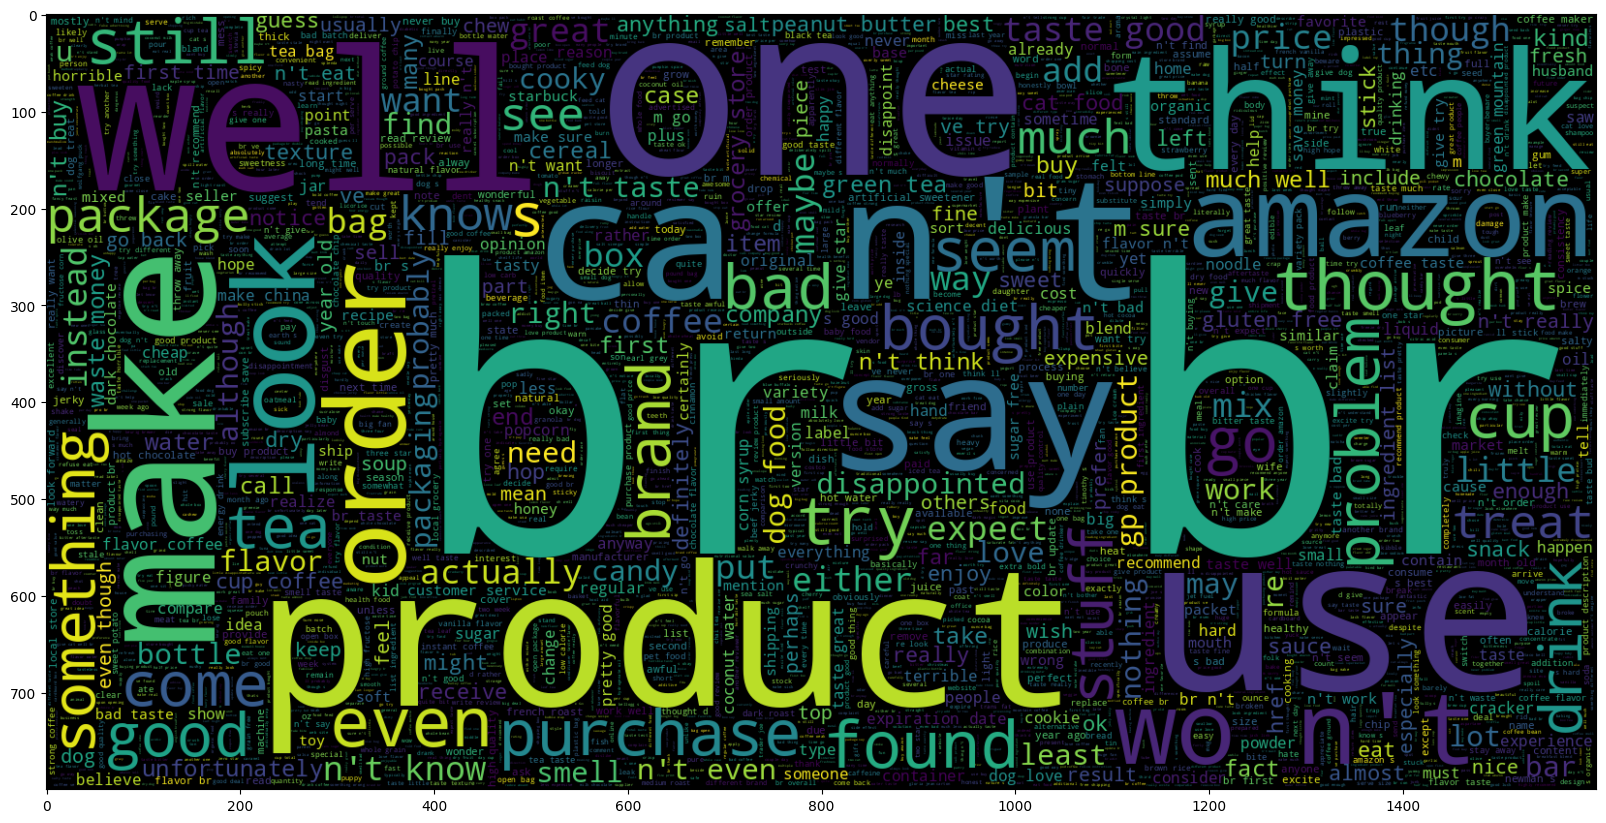

In [31]:
good = x_train[y_train[y_train >= 4].index]
bad = x_train[y_train[y_train <= 3].index]

plt.figure(figsize = (20,20)) # Text Reviews with Poor Ratings (visual purposes only)
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(bad))
plt.imshow(wc,interpolation = 'bilinear')

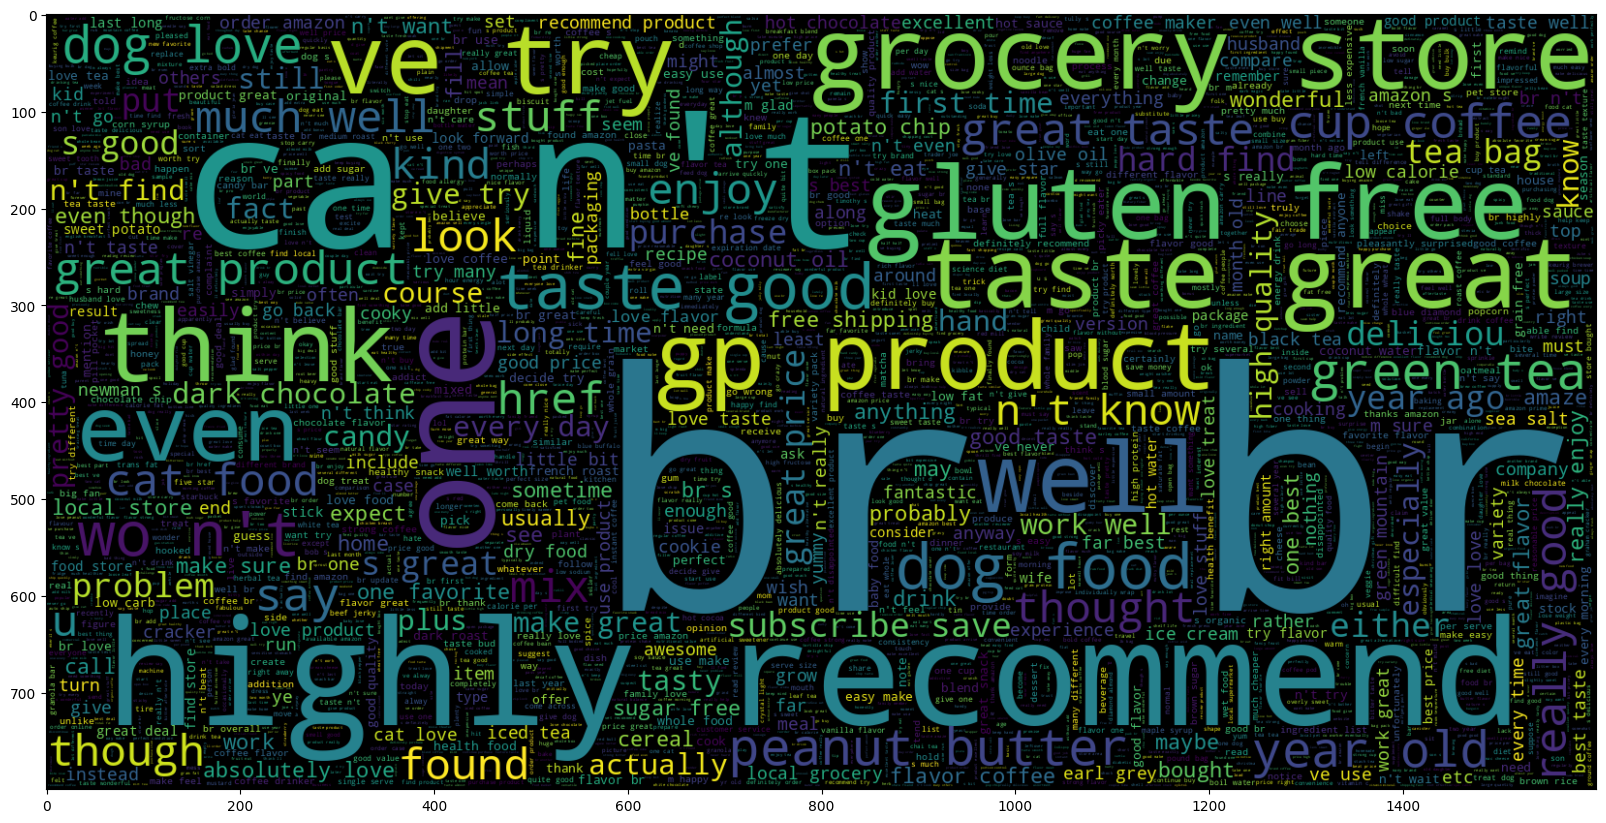

In [32]:
plt.figure(figsize = (20,20)) # Text Reviews with Good Ratings (visual purposes only)
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(good))
plt.imshow(wc,interpolation = 'bilinear')

## Featurize

In [33]:
path = project_folder + '/' + lr_model + '-count-vectorizer.pkl'

if save_model_to_drive:
  cv=CountVectorizer(binary=False,ngram_range=(1,3))
  cv.fit(x_train)

  # save
  with open(path, 'wb') as f:
    pickle.dump(cv, f)

  bow_train_reviews=cv.transform(x_train) #transformed train reviews
  print('BOW_cv_train:', bow_train_reviews.shape)

else:
  with open(path, 'rb') as f:
      cv = pickle.load(f)

bow_test_reviews=cv.transform(x_test) #transformed test reviews
print('BOW_cv_test:', bow_test_reviews.shape)

# Check how many words appear <= 10 times
print(sum([1 if v <= 10 else 0 for (k, v) in cv.vocabulary_.items()]))

BOW_cv_test: (170529, 11454254)
11


# Evaluation Metric

## Mean Squared Error

In [34]:
def get_mse(labels, pred):
  score = mean_squared_error(labels, pred)
  print("error :", score)

# Models

## Majority Class Baseline

In [35]:
maj_class_train = y_train.mode()
maj_class_test = y_test.mode()

maj_class_train_preds = np.full_like(y_train, maj_class_train)
maj_class_test_preds = np.full_like(y_test, maj_class_test)

In [36]:
maj_class_train_err = get_mse(maj_class_train_preds, y_train)
maj_class_test_err = get_mse(maj_class_test_preds, y_test)

error : 2.3808312683149953
error : 2.391751549589806


## Logistic Regression

### Training loop

In [37]:
if save_model_to_drive:
  lr=LogisticRegression(solver='sag', max_iter=500, random_state=0)

  # ~1 hour to execute
  lr_bow=lr.fit(bow_train_reviews, y_train) #Fitting the model for Bag of words
  print(lr_bow)

  # save
  path = project_folder + '/' + kaggle_dataset.split('/')[1] + '-lr-model.pkl'

  with open(path,'wb') as f:
      pickle.dump(lr_bow,f)

### Predict

In [38]:
lr_bow_predict=lr_bow.predict(bow_test_reviews)
get_mse(lr_bow_predict, y_test)

error : 0.6175606495082948


### Evaluate feature weights

In [39]:
k = 5
feature_names = cv.get_feature_names_out()
for i, row in enumerate(lr_bow.coef_):
  print("Most common word sequences for " + str(i + 1) + "-star reviews:", feature_names[np.argpartition(row, len(row) - k)[-k:]])
print()
for i, row in enumerate(lr_bow.coef_):
  print("Least common word sequences for " + str(i + 1) + "-star reviews:", feature_names[np.argpartition(row, k)[:k]])

Most common word sequences for 1-star reviews: ['one star' 'threw' 'awful' 'terrible' 'disgust']
Most common word sequences for 2-star reviews: ['give two' 'mediocre' 'disappointment' 'disappoint' 'two star']
Most common word sequences for 3-star reviews: ['average' 'give three' 'okay' 'ok' 'three star']
Most common word sequences for 4-star reviews: ['downside' 'reason give' 'star instead' 'four star' 'complaint']
Most common word sequences for 5-star reviews: ['perfect' 'delicious' 'wo disappointed' 'hooked' 'awesome']

Least common word sequences for 1-star reviews: ['best' 'delicious' 'awesome' 'great' 'excellent']
Least common word sequences for 2-star reviews: ['beat' 'delicious' 'excellent' 'wo disappointed' 'perfect']
Least common word sequences for 3-star reviews: ['well worth' 'one star' 'yum' 'hard find' 'hooked']
Least common word sequences for 4-star reviews: ['disgust' 'sorry' 'disappoint' 'two star' 'terrible']
Least common word sequences for 5-star reviews: ['wo buying'